<a href="https://colab.research.google.com/github/Soumojit20/SRIP-JAX-ASSISGNMENT/blob/main/Implement_two_hidden_layers_neural_network_classifier_from_scratch_in_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

QUESTION 3 :Implement two hidden layers neural network classifier from scratch in JAX 


In [ ]:

#Importing required libraries and functions
import jax 
import numpy as np
import jax.numpy as jnp 
from jax.scipy.special import logsumexp
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from jax import jit, vmap, pmap, grad, value_and_grad



In [ ]:
seed =0
mnist_img_size = (28, 28)
def init_MLP(layer_widths,parent_key,scale =0.01):
  params=[]
  keys=jax.random.split(parent_key,num=len(layer_widths)-1)

  for n_in,n_out,key in zip(layer_widths[:-1],layer_widths[1:],keys):
    weight_key,bias_key = jax.random.split(key)
    params.append(
        [scale*jax.random.normal(weight_key,shape=(n_out,n_in)),
         scale*jax.random.normal(bias_key,shape=(n_out,))
         ]
         )
    
  return params
key = jax.random.PRNGKey(seed)
mlp_params = init_MLP([784,512,256,10],key)

print(jax.tree_map(lambda x: x.shape,mlp_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [ ]:
#prediction function


def mlp_predict(params,x): 
  hidden_layers=params[:-1] 

  activation = x
  for w,b in hidden_layers:
    activation = jax.nn.relu(jnp.dot(w,activation)+b) #as each neuron has a activation function relu,tanh

  w_last,b_last = params[-1]
  logits = jnp.dot(w_last,activation)+ b_last
    
  return logits - logsumexp(logits) #calculate the cross entropy log(exp 01)-log(sum(exp 01,exp 02,....))

dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

prediction = mlp_predict(mlp_params,dummy_img_flat)
print(prediction.shape)

# test batched function

batched_MLP_predict = vmap(mlp_predict, in_axes=(None, 0))

dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(mlp_params, dummy_imgs_flat)
print(predictions.shape)



(784,)
(10,)
(16, 784)
(16, 10)


In [ ]:
def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

batch_size = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_mnist/MNIST/raw

(128, 784) float32 (128,) int64


In [ ]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from jax import jit, vmap, pmap, grad, value_and_grad

num_epochs = 5

def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs)

    return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_multimap(lambda p, g: p - lr*g, params, grads)

# Create a MLP
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    for cnt, (imgs, lbls) in enumerate(train_loader):

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
        
        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')

0.2433279
0.102504544
0.056961395
0.0500785
0.039622482
0.034935668
0.03342929
0.03110886
0.034086503
0.034533035
Epoch 0, train acc = 0.911050021648407 test acc = 0.915399968624115
0.03031689
0.021534814
0.027914155
0.028824715
0.02641722
0.02077927
0.024875863
0.02306728
0.023772936
0.04122649
Epoch 1, train acc = 0.9348500370979309 test acc = 0.9358999729156494
0.024765987
0.018216303
0.011826715
0.024876155
0.025867954
0.016070982
0.020118186
0.02364597
0.014108926
0.023243675
Epoch 2, train acc = 0.9467833638191223 test acc = 0.9438999891281128
0.01326817
0.010687888
0.008155701
0.017558342
0.014524213
0.021987729
0.01641966
0.017128697
0.020251468
0.008696633
Epoch 3, train acc = 0.9554333686828613 test acc = 0.9498999714851379
0.01057439
0.02544107
0.013735718
0.016963368
0.011788238
0.0138829
0.01835916
0.013869971
0.018620137
0.022822687
Epoch 4, train acc = 0.9599500298500061 test acc = 0.9551999568939209


(28, 28)
pred 7
gt 7


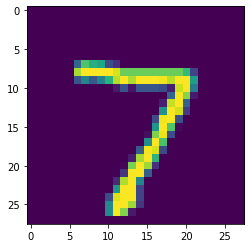

In [ ]:
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)
gt_lbl = lbls[0]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(mlp_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)

plt.imshow(img); plt.show()